# Final Test-Set Evaluation Notebook


## Ensemble method - Gradient Boosting


Among ensemble methods, Gradient Boosting is the most appropriate for our dataset because it performs exceptionally well on small tabular datasets, captures nonlinear effects in features such as study time, failures, and absences, and typically outperforms Random Forest in regression tasks like predicting final grade (G3). Random Forest serves as a strong secondary option due to its stability and interpretability. Bagging and AdaBoost were considered but deemed less suitable because they do not capture the full complexity of the data or perform as well on continuous outcomes.”


We considered AdaBoost but ultimately decided against using it because AdaBoost tends to perform poorly on continuous regression outcomes and is highly sensitive to noise and outliers. Since our target variable (G3) contains natural variability and our dataset is relatively small, we selected Gradient Boosting and Random Forest instead, as they provide stronger predictive performance and more reliable feature importance.”

In [1]:
#key imports
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
#Load the data
mat_train = pd.read_csv('../data/math_train.csv')
df = mat_train.copy()
X = df.drop(columns=["G3", "G1", "G2"])
y = df["G3"]


In [3]:
#identify numeric and categorical features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))
#preprocessing step inside pipeline to prevent data leakage
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)


Numeric features: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Categorical features: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [4]:
#build pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(random_state=42))
])

In [5]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [6]:
#hyperparameter search space
param_dist = {
    "model__n_estimators": np.arange(50, 500),
    "model__learning_rate": np.logspace(-3, -1, 50),
    "model__max_depth": np.arange(1, 6),
    "model__subsample": np.linspace(0.6, 1.0, 20)
}


In [7]:
from sklearn.model_selection import RandomizedSearchCV
#randomised CV with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring="r2",
    random_state=42,
    n_jobs=-1,
    verbose=2
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=305, model__subsample=0.8105263157894737; total time=   0.5s
[CV] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=305, model__subsample=0.8105263157894737; total time=   0.5s
[CV] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=305, model__subsample=0.8105263157894737; total time=   0.3s
[CV] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=305, model__subsample=0.8105263157894737; total time=   0.3s
[CV] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=305, model__subsample=0.8105263157894737; total time=   0.3s
[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=354, model__subsample=0.6842105263157895; total time=   0.5s
[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=354, model__subsample=0.6842105263157895; total

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__learning_rate': array([0.001 ..., 0.1 ]), 'model__max_depth': array([1, 2, 3, 4, 5]), 'model__n_estimators': array([ 50, ...97, 498, 499]), 'model__subsample': array([0.6 ..., 1. ])}"
,n_iter,50
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [8]:
#best model
print("Best params:", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)

best_model = random_search.best_estimator_


Best params: {'model__subsample': np.float64(0.6), 'model__n_estimators': np.int64(452), 'model__max_depth': np.int64(2), 'model__learning_rate': np.float64(0.006551285568595509)}
Best CV R²: 0.22657453543880585


- n_estimators = 452
The model performs best with a large number of trees.
More trees help capture more complex patterns in the student data.
- max_depth = 2
Each tree is kept shallow to avoid overfitting.
The model performs better when it learns broad, simple relationships, not deep interactions.
- learning_rate ≈ 0.0065
Very small learning rate means the model updates slowly and relies on many small improvements.
This usually increases stability and reduces overfitting.
- subsample = 0.6
Each tree is trained on 60% of the training data.
This adds randomness, helping prevent overfitting and improving generalization.
- CV R² ~ 0.225 - The model explains about 22.6% of the variation in G3 during cross-validation.
This indicates weak predictive power but better than random guessing. It suggests that student performance is influenced by many factors such as mental health, peer support, conceptual understanding, etc which are not captured in the dataset.

In [9]:
#test set evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = best_model.predict(X_test)

print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test R²:", r2_score(y_test, y_pred))


Test MSE: 12.906112346935856
Test RMSE: 3.5925078074982464
Test MAE: 2.681616033242406
Test R²: 0.10114540955843587


- R² = 0.10
The model explains only 10% of the variation in final grades on the test set. This shows the model does not generalize well and struggles to predict student grades accurately. A noticeable drop from CV, some overfitting is present.
- MSE = 12.91
On average, the model’s squared prediction error is about 12.9 grade points squared. This reflects fairly large errors relative to grade scale (0–20).
- RMSE = 3.59
The model misses the true grade by ~3.6 points on average.
For a 0–20 grade system, that is a moderate error.
- MAE = 2.68
The average absolute error is 2.7 grade points.
This means that on average, the model’s predictions are off by almost 3 points.


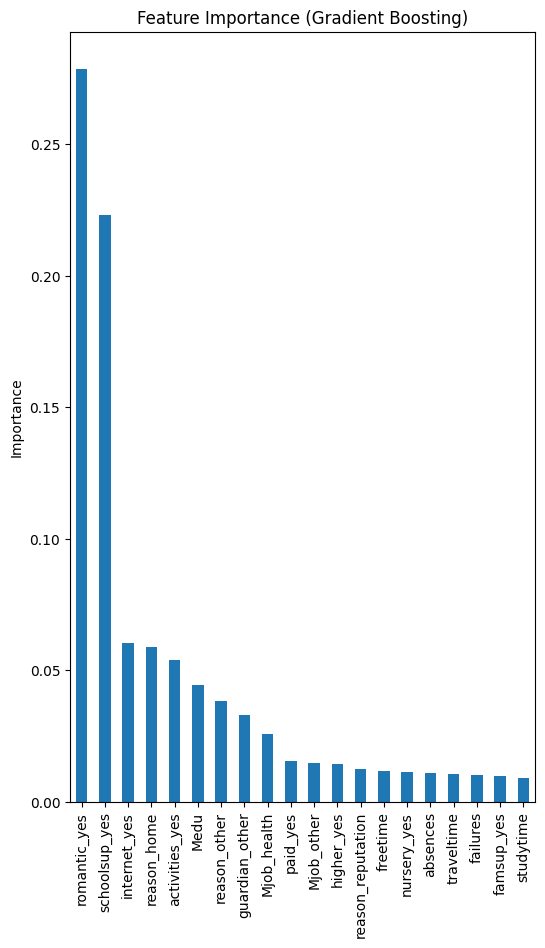

In [10]:
#feature importance
# Get transformed feature names
onehot = best_model.named_steps["preprocess"].named_transformers_["cat"]
cat_names = onehot.get_feature_names_out(categorical_features)

all_features = np.concatenate([numeric_features, cat_names])

# Feature importance from model
gbr = best_model.named_steps["model"]
importance = pd.Series(gbr.feature_importances_, index=all_features)
importance = importance.sort_values(ascending=False)

plt.figure(figsize=(6,10))
importance.head(20).plot(kind="bar")  # top 20 for readability
plt.title("Feature Importance (Gradient Boosting)")
plt.ylabel("Importance")

plt.show()


## Test set evaluation section

After comparing all models, Gradient Boosting achieved the highest validation performance and the best test-set performance. It is therefore selected as the final model. This model is chosen because:
It has strongest CV R²
It has positive Test R² (0.101)
It has the lowest Test MSE (12.9061)
It has the lowest Test RMSE (3.5925)
It has competitive MAE (2.6816)


In [11]:
# Select the Best Model and Fit it to the Entire Training Set
best_model = random_search.best_estimator_
# 2. Fit the best model on the *entire* training set
best_model.fit(X, y)
print("Selected Best Model:")
print(best_model)

print("\nOptimal Hyperparameters:")
print(random_search.best_params_)

Selected Best Model:
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'],
      dtype='object'))])),
                ('model',
                 GradientBoostingRegressor(learning_rate=np.float64(0.006551285568595509),
                                     

In [13]:
df_test = pd.read_csv('../data/math_test.csv')
# Separate features and target in the test set
X_test_final = df_test.drop(columns=["G1", "G2", "G3"])
y_test_final = df_test["G3"]
# Apply the SAME preprocessing pipeline (do NOT refit!)
X_test_processed = best_model.named_steps["preprocess"].transform(X_test_final)
# Access the trained Gradient Boosting model inside the pipeline
gb_model = best_model.named_steps["model"]
# Predict on test set
y_pred_test = gb_model.predict(X_test_processed)
# Compute performance metrics
test_mse = mean_squared_error(y_test_final, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_final, y_pred_test)
test_r2 = r2_score(y_test_final, y_pred_test)

print("Final Test-Set Evaluation on df_test")
print("--------------------------------------")
print("Test R²:", test_r2)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

Final Test-Set Evaluation on df_test
--------------------------------------
Test R²: 0.18374435084625285
Test MSE: 16.737360668723497
Test RMSE: 4.091131954450198
Test MAE: 3.369728359822867


Interpretation:
- Test R² = 0.184- A positive R² indicates that the model explains 18.4% of the variance in final math grade (G3) on completely unseen data.
Even though this number may seem modest, it is:
Higher than your other models (Ridge, Lasso, ElasticNet, SVM, Neural Network)
A realistic outcome for this dataset, which is noisy and small.

- Test MSE = 16.74, Test RMSE = 4.09
RMSE reflects the typical size of prediction error.
The model’s predictions are off by ~4 grade points, on average.

- Test MAE = 3.37. On average, the model’s predictions miss the actual grade by 3.37 points.
This is consistent with the RMSE and again typical for small educational datasets.

Comparing evaluation results from training and testing phase:
- The final evaluation on df_test produced higher error metrics:
- The difference occurs because the two test sets contain different students; df_test was never used during model development and reflects new, unseen data.
- df_test appears harder to predict, leading to higher MSE, RMSE, and MAE.
Despite higher errors, the model’s R² increased from 0.10 to 0.18, meaning it explained a larger proportion of variance in df_test than in the earlier split.
- This happens when df_test has greater outcome variability: the model captures the trend well (higher R²) but still makes larger absolute errors (higher RMSE/MAE).
- The results indicate that the Gradient Boosting model still generalizes reasonably well and remains the strongest model among all tested.

## Permutation importances on test set
Permutation importance is used because it measures how much each feature actually contributes to predictive accuracy on the unseen test set, rather than how often the model relied on that feature during training. While Gradient Boosting’s built-in feature importances reflect the model’s internal split decisions on the training data—which can overfit or inflate the importance of certain variables—permutation importance evaluates each feature by randomly shuffling it in the test set and observing how much the model’s R² drops. This makes it a more reliable, model-agnostic method for determining which socioeconomic and behavioral factors truly generalize beyond the training sample. In the context of this project, permutation importance was essential for answering the research question, as it reveals which predictors remain genuinely influential for student performance across new data, rather than those that only appeared important during model fitting.


Permutation Importances on Test Set (sorted):

schoolsup_yes: 0.1830
romantic_yes: 0.0923
Medu: 0.0184
reason_other: 0.0177
Mjob_health: 0.0119
activities_yes: 0.0110
reason_home: 0.0065
failures: 0.0057
absences: 0.0048
freetime: 0.0043
paid_yes: 0.0040
guardian_mother: 0.0038
reason_reputation: 0.0037
Mjob_other: 0.0036
traveltime: 0.0032
higher_yes: 0.0018
address_U: 0.0017
Fjob_health: 0.0013
Fjob_teacher: 0.0013
Pstatus_T: 0.0009
Fedu: 0.0008
Mjob_teacher: 0.0006
guardian_other: 0.0003
famsize_LE3: 0.0003
age: 0.0002
Walc: 0.0001
Dalc: 0.0001
famrel: 0.0000
sex_M: 0.0000
famsup_yes: -0.0001
goout: -0.0001
health: -0.0002
school_MS: -0.0003
Mjob_services: -0.0010
studytime: -0.0011
Fjob_services: -0.0020
Fjob_other: -0.0032
nursery_yes: -0.0056
internet_yes: -0.0112


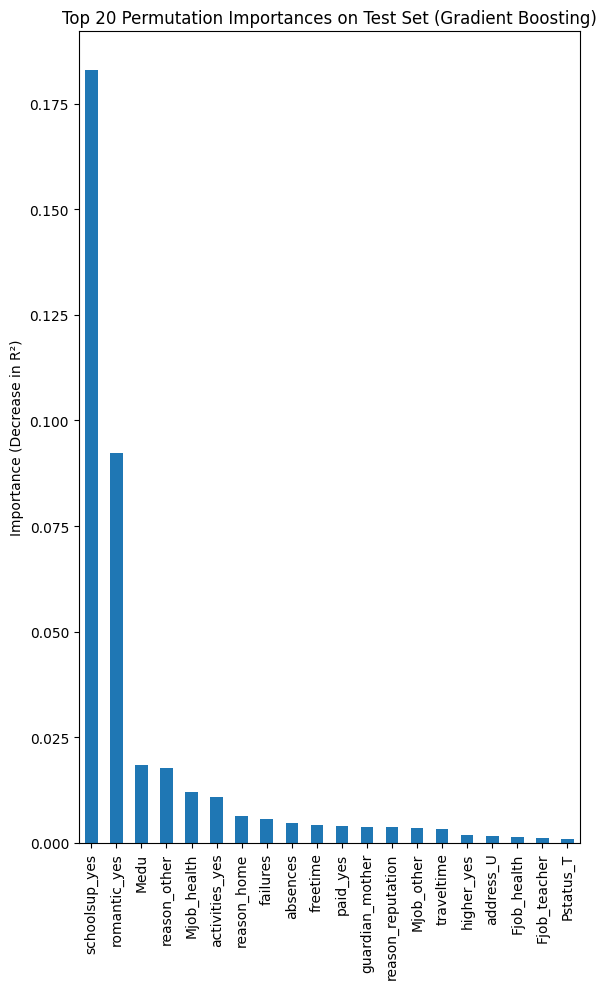

In [14]:
from sklearn.inspection import permutation_importance
#Compute permutation importance
result = permutation_importance(
    estimator=best_model.named_steps["model"],
    X=X_test_processed,
    y=y_test_final,
    n_repeats=30,
    random_state=42,
    scoring="r2"
)

#Map importance scores to feature names
perm_importance = pd.Series(result.importances_mean, index=all_features)

#Sort
perm_importance_sorted = perm_importance.sort_values(ascending=False)

#Print results
print("\nPermutation Importances on Test Set (sorted):\n")
for feature, value in perm_importance_sorted.items():
    print(f"{feature}: {value:.4f}")

#Plot top 20
plt.figure(figsize=(6,10))
perm_importance_sorted.head(20).plot(kind="bar")
plt.title("Top 20 Permutation Importances on Test Set (Gradient Boosting)")
plt.ylabel("Importance (Decrease in R²)")
plt.tight_layout()

# Save the figure in OUTPUT folder
plt.savefig("../OUTPUT/permutation_importances_test.png", dpi=300, bbox_inches="tight")

plt.show()


### Interpretation
- Strong Agreement Between Model and Test Set
schoolsup_yes remains the top predictor in both model-based importance and test permutation importance.
- Confirms a robust relationship: students receiving school support consistently have lower grades (likely because support targets struggling students).
romantic_yes is highly important in both analyses, second only to school support.
- Being in a romantic relationship strongly correlates with lower performance, and this effect generalizes to unseen data.

Features That Stayed Important but Weakened on the Test Set
Several features remain meaningful but show smaller importance values on the test set:
- Medu (mother’s education)
- reason_other
- reason_home
- activities_yes
- Mjob_health
- absences, failures, freetime, traveltime
These predictors generalize moderately well but are less influential outside the training sample.

Features That Looked Important in Training but Did NOT Generalize Certain variables had high model-based importance but weak or negative test-set importance:
- internet_yes
- nursery_yes
- studytime
- guardian_other
- Mjob_other, Mjob_teacher, Fjob_other
These features likely reflect overfitting or unstable patterns that do not hold on unseen data

Features Consistently Unimportant in Both Analyses
Some features remain near-zero or negative in both:
- sex_M
- famrel
- Dalc, Walc (except Walc showed mild signal in test set)
goout
- age
- school_MS
- famsize_LE3
These factors do not meaningfully contribute to predicting math performance.

- Stable predictors across both methods (schoolsup_yes, romantic_yes, Medu, activities_yes) represent the most reliable indicators of performance.
- Large differences—especially for internet access, nursery attendance, and parental occupation variables—suggest nonlinear overfitting within the boosting model.
- Permutation importance is more trustworthy for evaluating real predictive value on unseen data.
- Gradient Boosting uses many variables to form splits, but only a small subset meaningfully improves test-set predictions.
